In [1]:
import collections
import functools
import os
import pathlib

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

/projects/b1196/envs/serniczek/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200
%config InlineBackend.figure_format = "retina"

In [3]:
from IPython.display import display, HTML
display(HTML("""
<style>
.lm-Widget {overflow-x: scroll !important;}
</style>
"""))

# Pathogen pseudobulk DEG analysis summary

## Methods:
To find differentially-expressed genes between pathogen groups (7) and control groups (2), we use pseudobulk approach with certain modification, detailed below. Pseudobulk approach shows better agreement with bulk approach during benchmarking (Squair et al., Nat Commun, 2021) compared to tests that do not account for cells’ belonging to different samples, and does not suffer from inflated p-values.

First, we prepared pseudobulk samples from our single-cell data. For each annotated cell type $T$, we excluded samples that didn’t have 50 cells (determined in [this notebook](https://github.com/NUPulmonary/serniczek/blob/main/05_pseudobulk/01_pseudobulk_number.ipynb)). Each sample belongs to strictly one pathogen or control group $G$. Next, we excluded genes that are not consistently expressed in the data from differential gene expression analysis: if a gene was detected (count > 0) in less than 80% of pseudobulk samples after filtering from sample group $G$, we excluded that gene. We also excluded 
* mitochondrial genes
* ribosomal genes
* genes with certain name patterns (see [here](https://www.biostars.org/p/9553891/))

For full gene exclusion code see: [\[1\]](https://github.com/NUPulmonary/serniczek/blob/main/02b_integration/10_raw-object.ipynb), [\[2\]](https://github.com/NUPulmonary/serniczek/blob/main/04b_geneformer/05a_gene_filtering_pseudobulk.ipynb).

**NB**: 
> is it right to exclude these genes before running DESeq2? It increases power but affects counts of the pseudobulks. Maybe a more correct procedure would be to:
> 1. Sum all detected genes for pseudobulks
> 2. Construct DESeq2 object with normalization
> 3. Run DE tests
> 4. Remove genes from test results
> 5. Redo FDR correction on the set of selected genes

Then we summed up raw gene counts for all cells in that sample that belong to the annotated cell type $T$ (see [here](https://github.com/NUPulmonary/serniczek/blob/main/05_pseudobulk/10_pathogen_pseudobulk.ipynb)).
Next, we constructed DESeq2 object will all pathogen and control groups (9 total) together with model expression `~ group + sex` and fitType set to `'local'`. Finally, we performed pairwise differential gene expression testing between each pathogen group and each control group (14 tests maximum) where we found at least 3 samples on both sides. We discarded genes that had `baseMean` expression of less than `50`. We used adjusted p-values from DESeq2 to determine significant up- or down-regulated genes at 0.05 alpha threshold. Code is in [this notebook](https://github.com/NUPulmonary/serniczek/blob/main/05_pseudobulk/11_pathogen_deseq2.R).

## Goals:

1. Summarize all comparisons that we ran
   1. Number of samples
   2. Number of DEGs up, down, both 

In [4]:
ROOT = pathlib.Path('/projects/b1196/ewa_group/serniczek/data')
BASE = ROOT / '05_pseudobulk/10_pathogen'

In [5]:
sc_meta = pd.read_csv(
    ROOT / '02b_integration/09_final_full-1/09_final_full-1-metadata.csv',
    index_col=0
)

/tmp/ipykernel_62487/4000152471.py:1: DtypeWarning: Columns (27,28,32,33,36,37,46,50,52,54,55,56,63) have mixed types. Specify dtype option on import or set low_memory=False.
  sc_meta = pd.read_csv(


In [6]:
pseudobulk_n_cells = sc_meta.groupby(['individual', 'Level_6']).size().reset_index(name='n_cells')

In [7]:
pseudobulk_n_cells = pseudobulk_n_cells.loc[pseudobulk_n_cells.n_cells.ge(50)].copy()

In [8]:
sample_to_group = sc_meta.groupby('individual').head(1).set_index('individual').perturbation_groups

In [9]:
pseudobulk_n_cells['group'] = sample_to_group[pseudobulk_n_cells.individual].values

In [10]:
pseudobulk_n_cells = pseudobulk_n_cells.loc[pseudobulk_n_cells.group.ne('discard')].copy()

In [11]:
pseudobulk_n_cells.rename(columns={'individual': 'sample', 'Level_6': 'cell_type'}, inplace=True)

In [12]:
class ComparisonInfo:
    def __init__(self, control, condition, genes, pseudobulk_info):
        self.control = control
        self.condition = condition
        self.n_control = pseudobulk_info.group.eq(control).sum()
        self.n_condition = pseudobulk_info.group.eq(condition).sum()
        self.genes_raw = genes
        self.genes = genes.loc[genes.baseMean.ge(50)].copy()

    @property
    def degs_control(self, alpha=0.05):
        return self.genes.loc[self.genes.padj.lt(alpha) & self.genes.log2FoldChange.gt(0)]

    @property
    def degs_condition(self, alpha=0.05):
        return self.genes.loc[self.genes.padj.lt(alpha) & self.genes.log2FoldChange.lt(0)]


class CellTypeInfo:
    def __init__(self, path, pseudobulk_n_cells):
        self.path = path
        self.comparisons = []
        meta = pd.read_csv(path / 'data/meta.csv')
        self.name = meta.cell_type.values[0]

        pseudobulk_info = pseudobulk_n_cells.loc[pseudobulk_n_cells.cell_type.eq(self.name)]
        self.load_comparisons(pseudobulk_info)

    def load_comparisons(self, pseudobulk_info):
        for run in self.path.glob('**/_deseq2.csv'):
            info = pd.read_csv(run).iloc[0]
            self.comparisons.append(
                ComparisonInfo(
                    info.control, 
                    info.condition,
                    pd.read_csv(run.parent / 'degs.csv'),
                    pseudobulk_info
                )
            )

    @property
    def n_comparisons(self):
        return len(self.comparisons)

    @property
    def n_healthy_comparisons(self):
        return len([x for x in self.comparisons if x.control == 'Healthy'])

    @property
    def n_npc_comparisons(self):
        return len([x for x in self.comparisons if x.control == 'NPC'])

In [13]:
%%time
data = []
for cell_type_path in sorted(BASE.iterdir()):
    info = CellTypeInfo(cell_type_path, pseudobulk_n_cells)
    if info.n_comparisons > 0:
        data.append(info)

CPU times: user 5.01 s, sys: 300 ms, total: 5.31 s
Wall time: 11.1 s


Text(0.5, 0, 'Number of DEG comparisons')

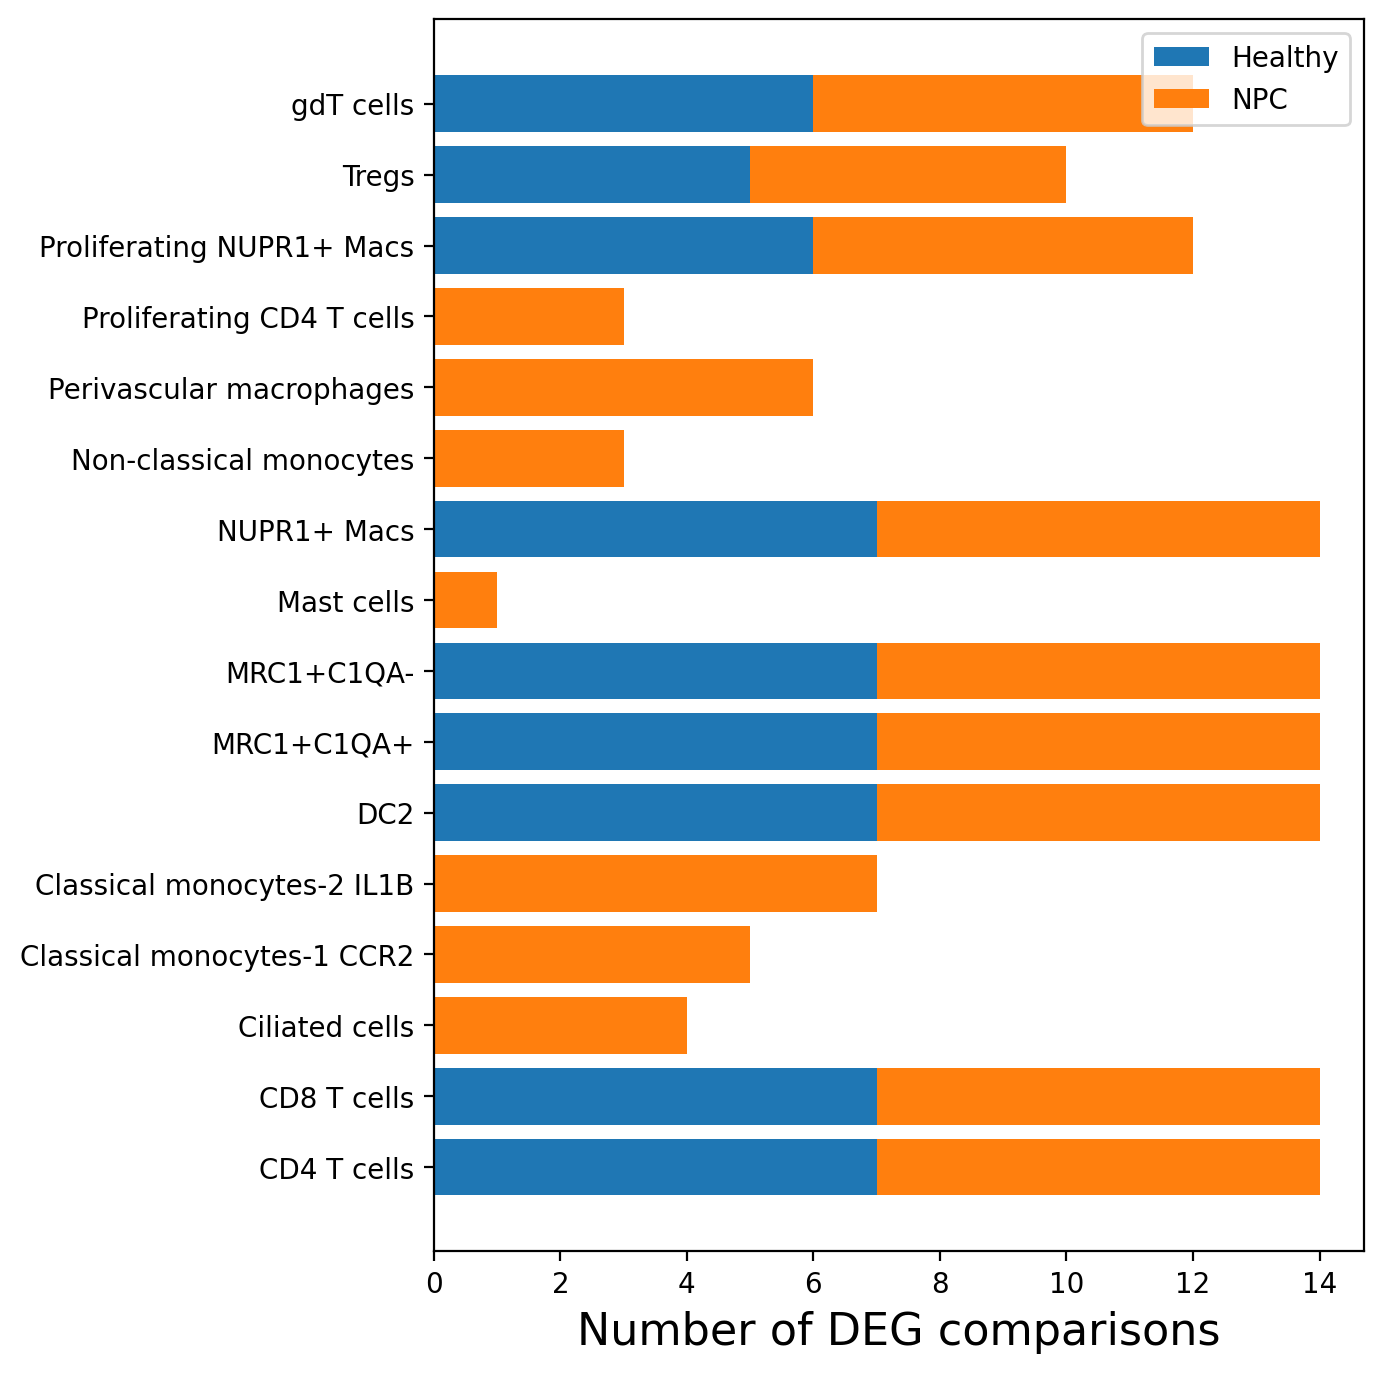

In [14]:
fig, ax = plt.subplots(figsize=(6, 8))
left = np.zeros(len(data))
ax.barh(range(len(data)), [i.n_healthy_comparisons for i in data], left=left, label='Healthy')
left += np.array([i.n_healthy_comparisons for i in data])
ax.barh(range(len(data)), [i.n_npc_comparisons for i in data], left=left, label='NPC')
ax.set_yticks(range(len(data)), labels=[i.name for i in data]);
ax.legend()
ax.set_xlabel('Number of DEG comparisons', size=16)

Text(0.5, 0, 'Number of DEG comparisons')

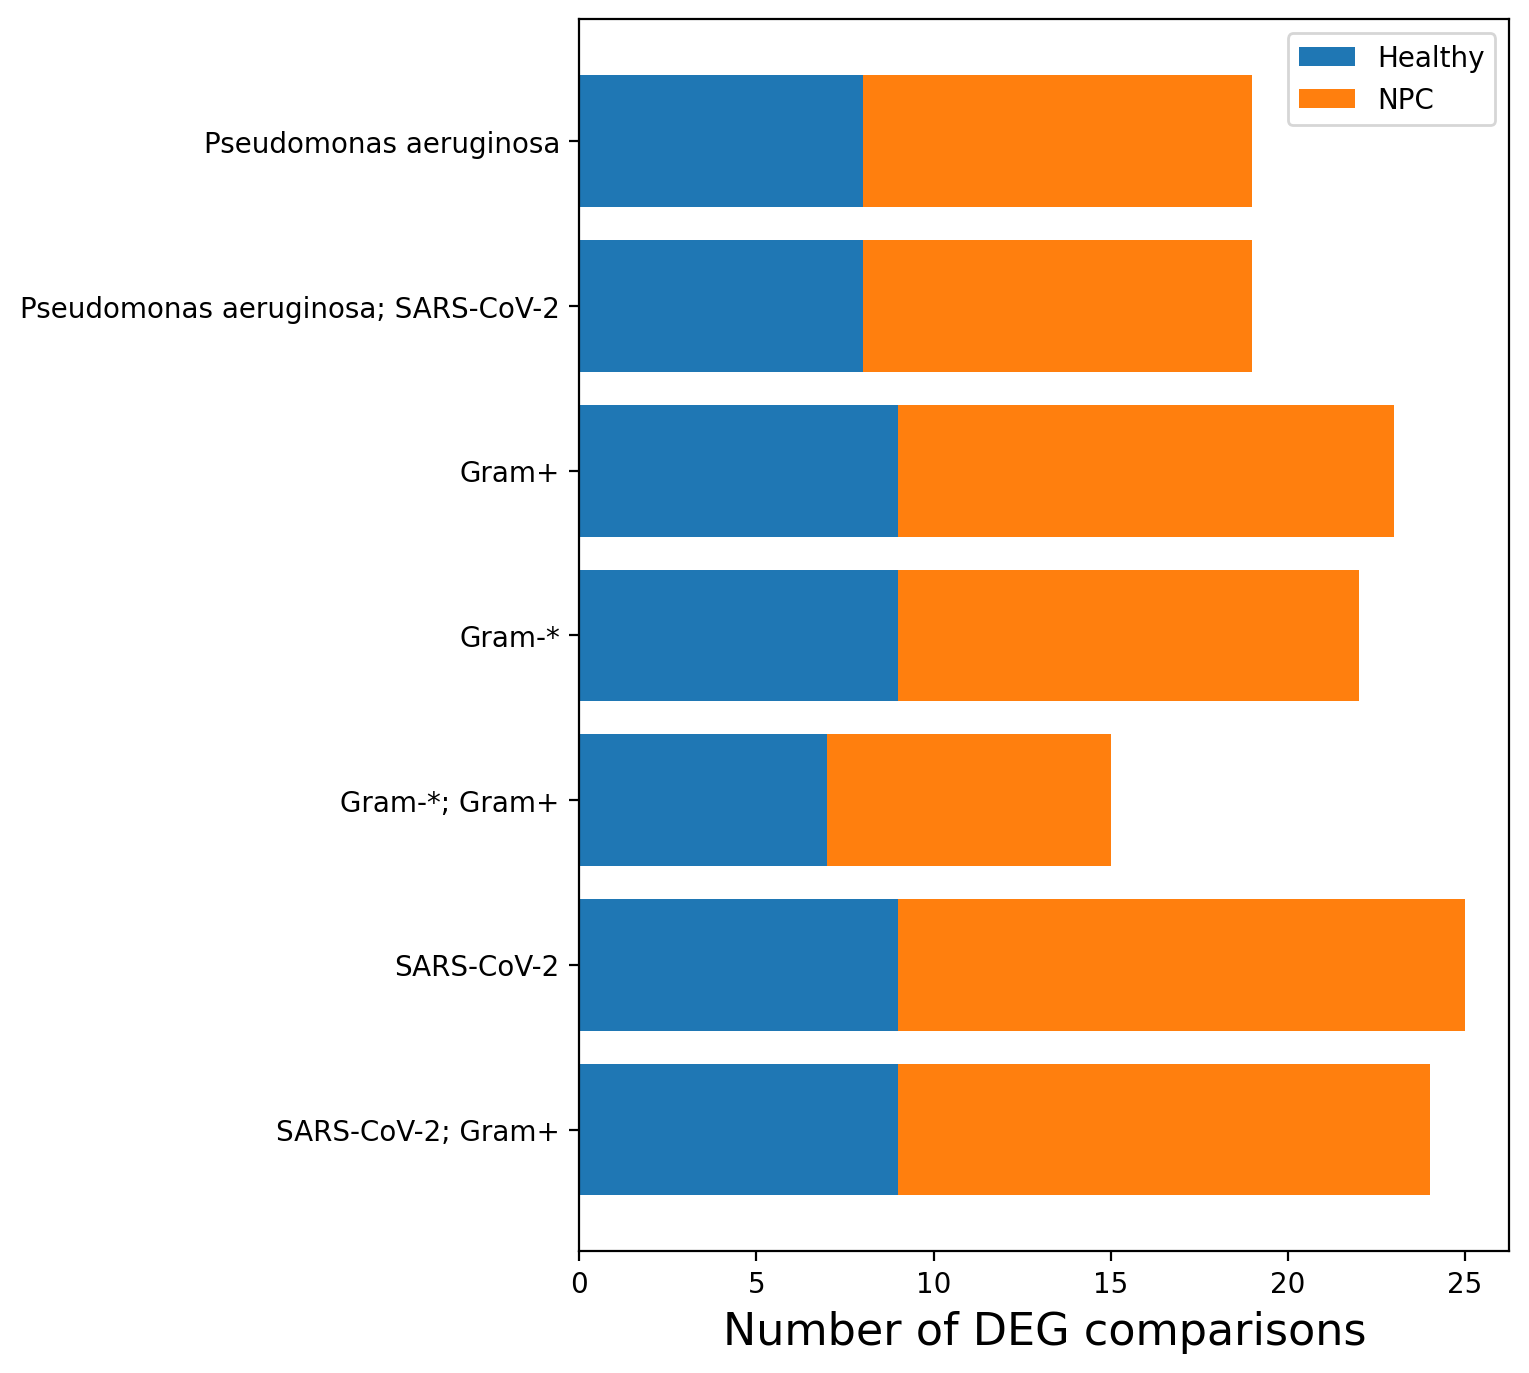

In [15]:
n_comparisons = {}
for i in data:
    for c in i.comparisons:
        if c.control == 'Healthy':
            n_comparisons.setdefault(c.condition, [0, 0])[0] += 1
        else:
            n_comparisons.setdefault(c.condition, [0, 0])[1] += 1

fig, ax = plt.subplots(figsize=(6, 8))
left = np.zeros(len(n_comparisons))
ax.barh(range(len(n_comparisons)), [i[0] for i in n_comparisons.values()], left=left, label='Healthy')
left += np.array([i[0] for i in n_comparisons.values()])
ax.barh(range(len(n_comparisons)), [i[1] for i in n_comparisons.values()], left=left, label='NPC')
ax.set_yticks(range(len(n_comparisons)), labels=n_comparisons.keys());
ax.legend()
ax.set_xlabel('Number of DEG comparisons', size=16)

In [29]:
n_degs_plot = pd.DataFrame()
n_degs = pd.DataFrame()
for i in data:
    for c in i.comparisons:
        name = c.control + ' vs ' + c.condition.replace(' aeruginosa', '')
        n_genes = c.genes.padj.lt(0.05).sum()
        n_degs.loc[i.name, name] = n_genes
        if n_genes > 0:
            n_genes = np.log10(n_genes)
        n_degs_plot.loc[i.name, name] = n_genes
n_degs = n_degs.T.sort_index()
n_degs_plot = n_degs_plot.T.sort_index()

Text(0.5, 1.0, 'Number of DEGs')

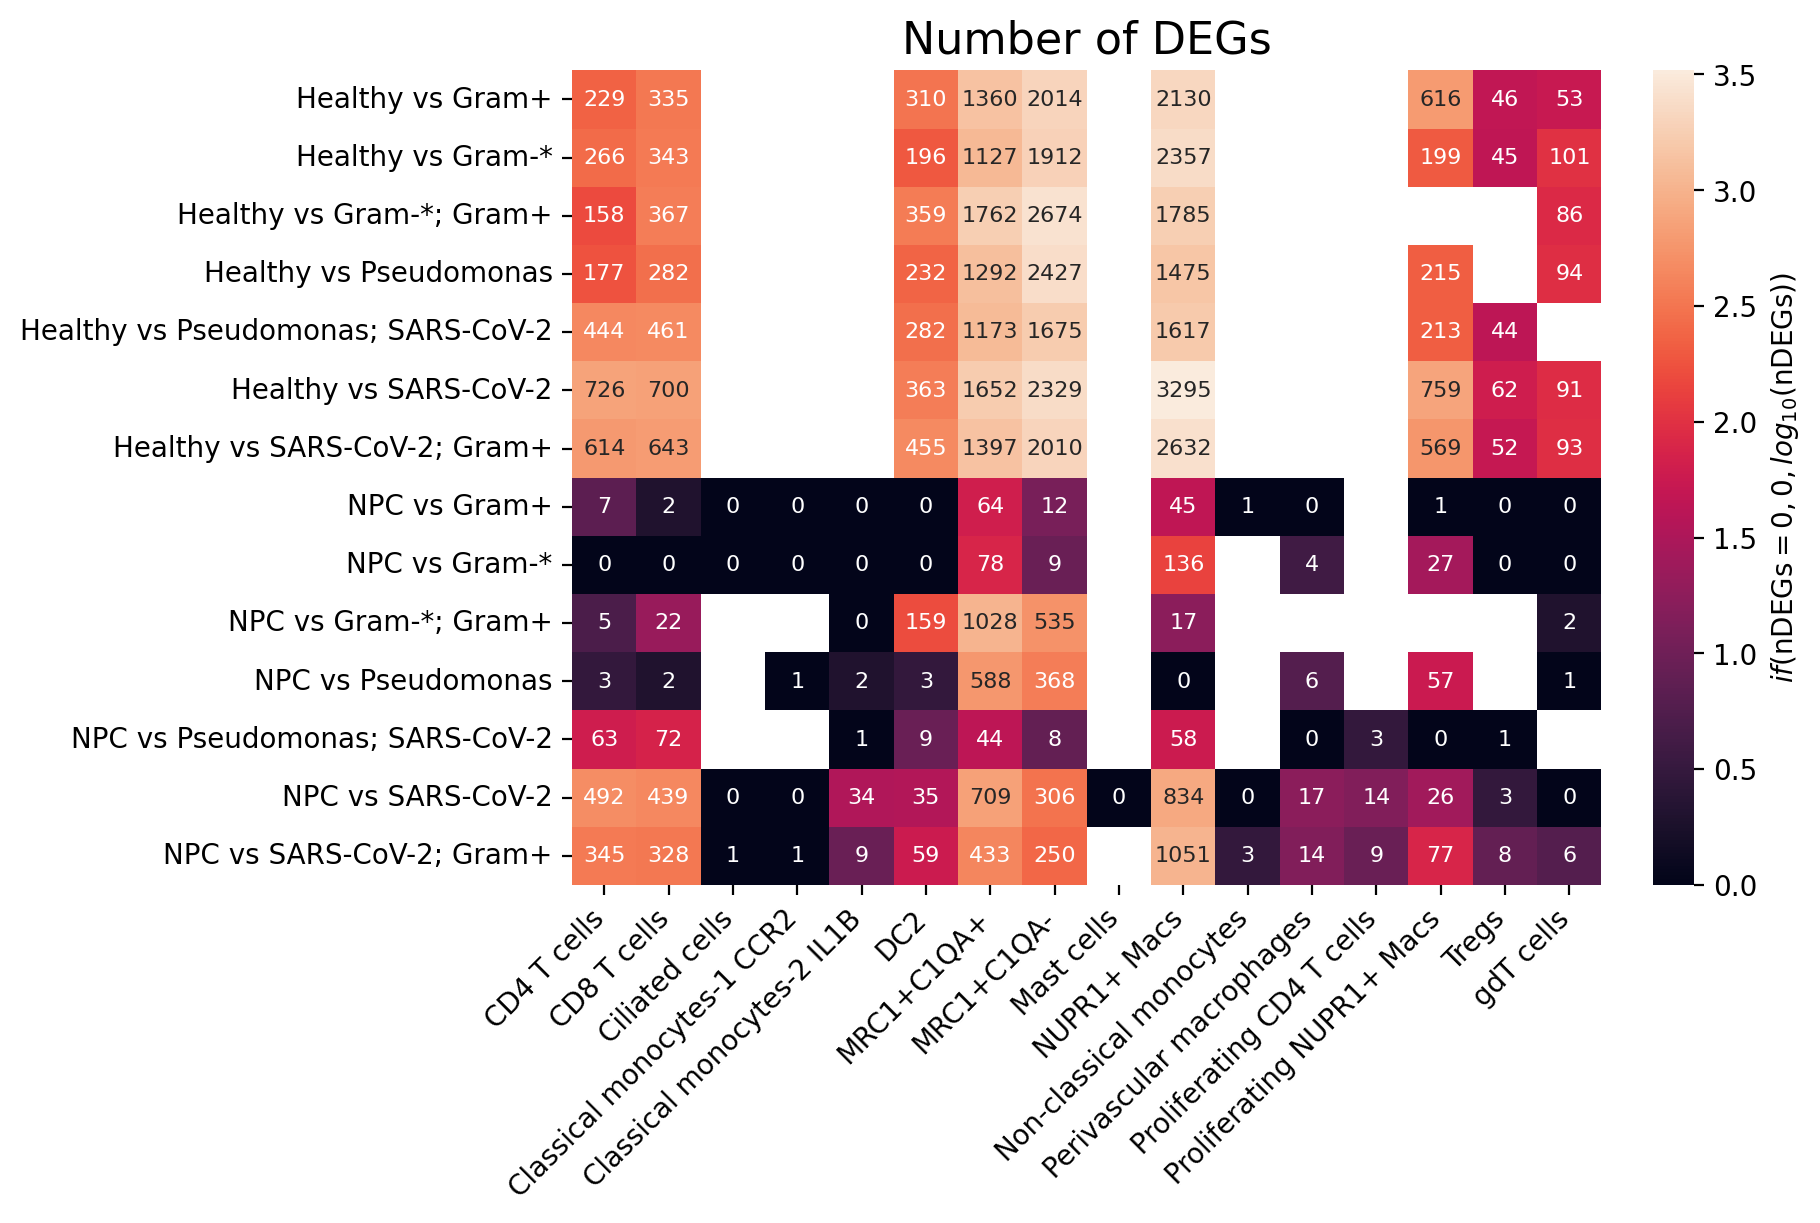

In [30]:
fig, ax = plt.subplots(figsize=(9, 6), constrained_layout=True)
sns.heatmap(
    n_degs_plot,
    cbar_kws=dict(
        label='$if(\mathrm{nDEGs} = 0, 0, log_{10}(\mathrm{n DEGs}))$'
    ),
    annot=n_degs,
    fmt='.0f',
    annot_kws=dict(
        size=8
    ),
    ax=ax
)
trans = mpl.transforms.Affine2D().translate(6, 0)
for t in ax.get_xticklabels():
    t.set_ha('right')
    t.set_rotation(45)
    t.set_transform(t.get_transform() + trans)
ax.set_title('Number of DEGs', size=16)

In [31]:
n_degs = pd.DataFrame()
n_degs_plot = pd.DataFrame()
for i in data:
    for c in i.comparisons:
        name = c.control + ' vs ' + c.condition.replace(' aeruginosa', '')
        n_genes = c.degs_control.shape[0]
        n_degs.loc[i.name, name] = n_genes
        if n_genes > 0:
            n_genes = np.log10(n_genes)
        n_degs_plot.loc[i.name, name] = n_genes
n_degs = n_degs.T.sort_index()
n_degs_plot = n_degs_plot.T.sort_index()

Text(0.5, 1.0, 'Number of DEGs up in controls')

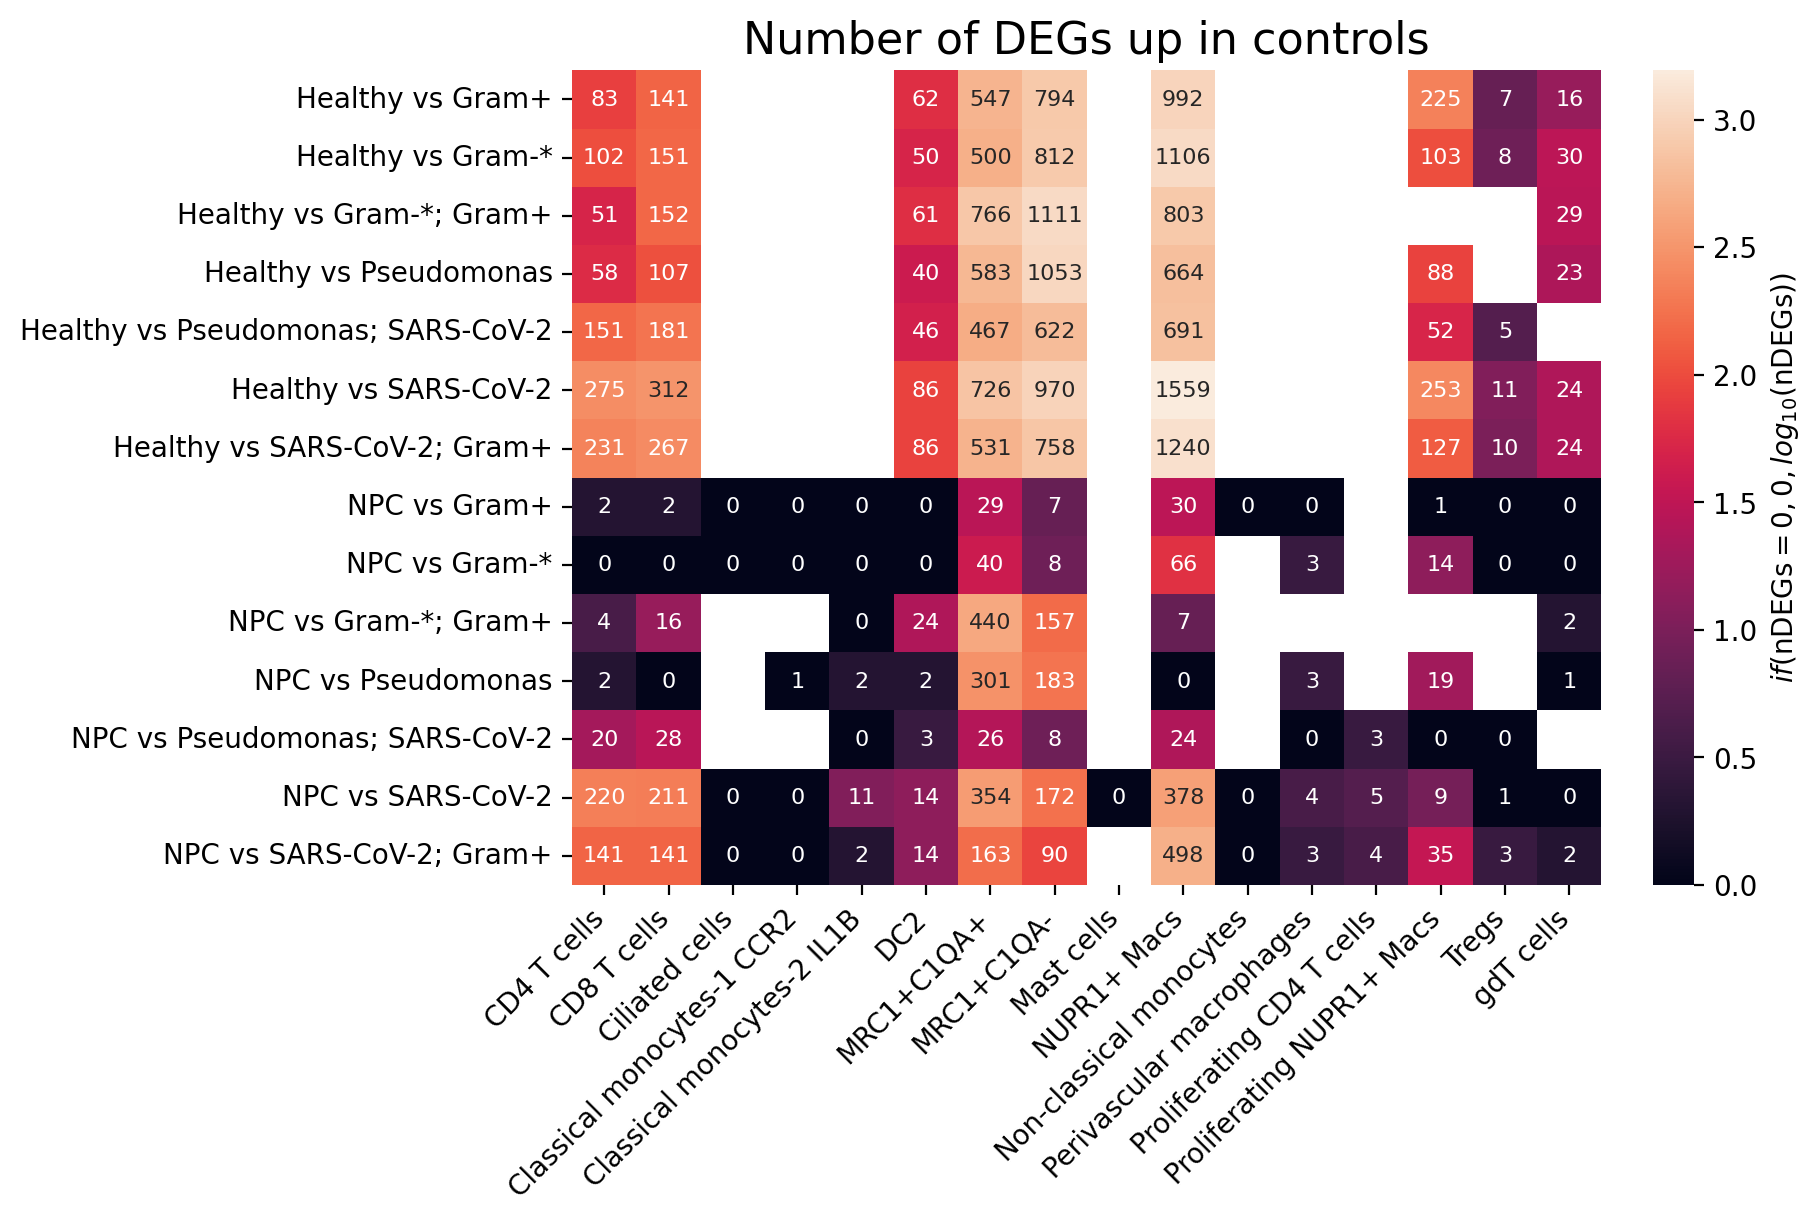

In [32]:
fig, ax = plt.subplots(figsize=(9, 6), constrained_layout=True)
sns.heatmap(
    n_degs_plot,
    cbar_kws=dict(
        label='$if(\mathrm{nDEGs} = 0, 0, log_{10}(\mathrm{n DEGs}))$'
    ),
    annot=n_degs,
    fmt='.0f',
    annot_kws=dict(
        size=8
    ),
    ax=ax
)
trans = mpl.transforms.Affine2D().translate(6, 0)
for t in ax.get_xticklabels():
    t.set_ha('right')
    t.set_rotation(45)
    t.set_transform(t.get_transform() + trans)
ax.set_title('Number of DEGs up in controls', size=16)

In [33]:
n_degs = pd.DataFrame()
n_degs_plot = pd.DataFrame()
for i in data:
    for c in i.comparisons:
        name = c.control + ' vs ' + c.condition.replace(' aeruginosa', '')
        n_genes = c.degs_condition.shape[0]
        n_degs.loc[i.name, name] = n_genes
        if n_genes > 0:
            n_genes = np.log10(n_genes)
        n_degs_plot.loc[i.name, name] = n_genes
n_degs = n_degs.T.sort_index()
n_degs_plot = n_degs_plot.T.sort_index()

Text(0.5, 1.0, 'Number of DEGs up with pathogen')

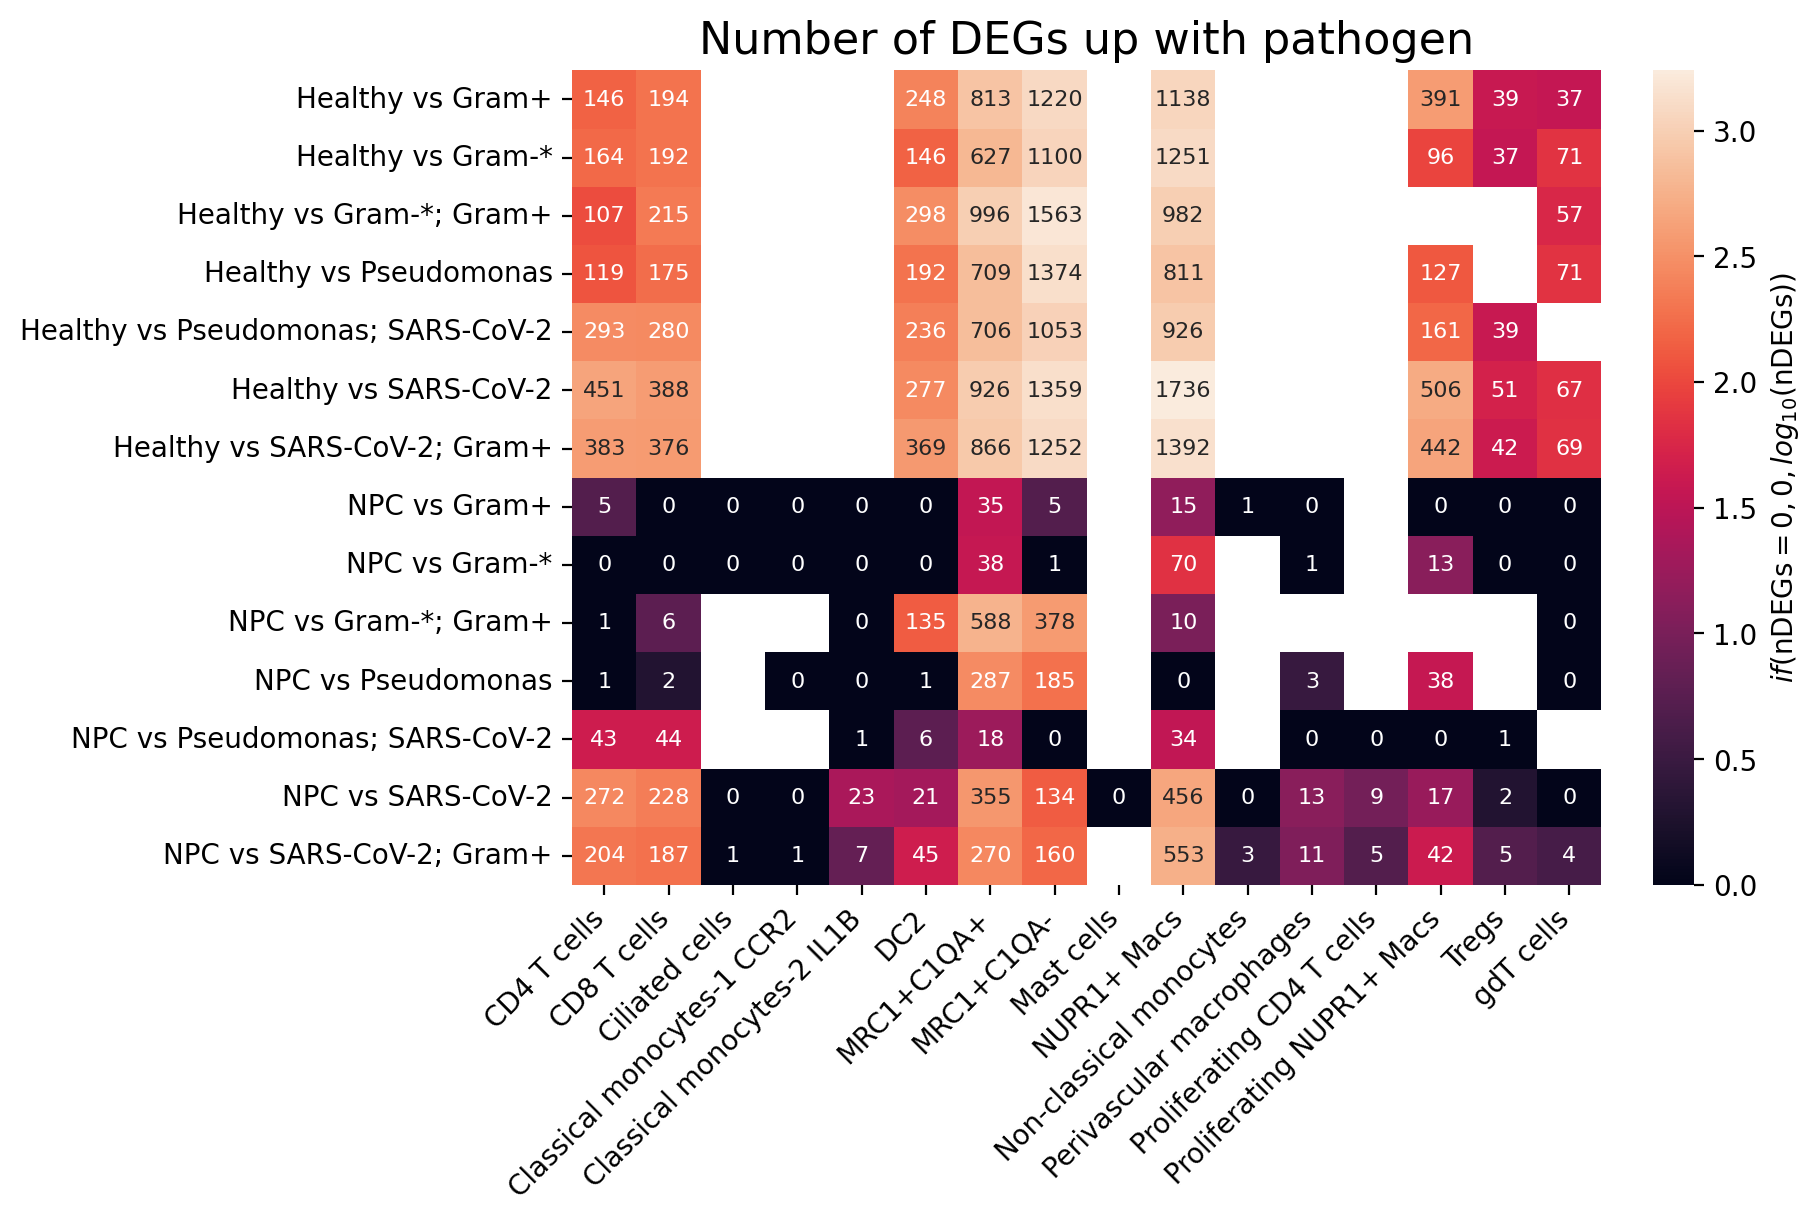

In [34]:
fig, ax = plt.subplots(figsize=(9, 6), constrained_layout=True)
sns.heatmap(
    n_degs_plot,
    cbar_kws=dict(
        label='$if(\mathrm{nDEGs} = 0, 0, log_{10}(\mathrm{n DEGs}))$'
    ),
    annot=n_degs,
    fmt='.0f',
    annot_kws=dict(
        size=8
    ),
    ax=ax
)
trans = mpl.transforms.Affine2D().translate(6, 0)
for t in ax.get_xticklabels():
    t.set_ha('right')
    t.set_rotation(45)
    t.set_transform(t.get_transform() + trans)
ax.set_title('Number of DEGs up with pathogen', size=16)